# Practice of Sampling in Grid-based Random Simulation
- data: Oyama
- conditions:
    `RandomInGrid`
    1. 10x10 samples (subarea size: 3x3)
    2. 5x5 samples (subarea size: 6x6)
    3. 2X2 samples (subarea size: 15x15)
- GP model: `KISSGPRegression`

In [1]:
from typing import List

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sparcity import Coord, subarea, TestData
from sparcity.dataset import load_oyama
from sparcity.gaussian_process import KISSGPRegression
from sparcity.metrics import absolute_error as ae
from sparcity.metrics import mean_absolute_error_score as mae
from sparcity.pipeline import ComparisonPipeline
from sparcity.random import random_coord
from sparcity.sampler import RandomInGrid

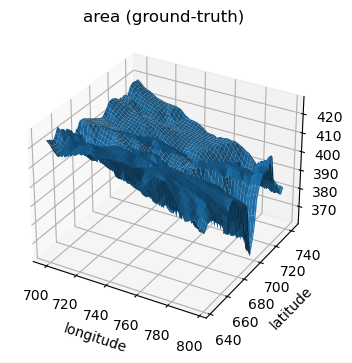

In [2]:
# Make area with oyama data

oyama = load_oyama(as_Coord=True)
area = subarea(*random_coord(oyama, 123), length=100, field=oyama)

fig = plt.figure(figsize=(4, 4), facecolor="w")
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(**area())
ax.set(xlabel="longitude", ylabel="latitude", title="area (ground-truth)");

---
## Comparison of Models
- metric: mean absolute error (MAE)

In [3]:
# Define a class to manage conditions

class Conditions:
    def __init__(
        self,
        lst_n_x: List[int],
        lst_n_y: List[int],
        lst_length: List[int]
    ) -> None:
        self.n_x = lst_n_x
        self.n_y = lst_n_y
        self.length = lst_length

    def __iter__(self):
        for x, y, l in zip(
            self.n_x,
            self.n_y,
            self.length
        ):
            yield x, y, l

In [4]:
conditions = Conditions(
    [10, 5, 2],
    [10, 5, 2],
    [3, 6, 15]
)

titles = [f"{x}x{y} samples (size:{l}x{l})" for x, y, l in conditions]

In [5]:
trains = [
    RandomInGrid(
        n_x=x, n_y=y, length=l, field=area, seed=0
    ) for x, y, l in conditions
]

In [6]:
pipeline = ComparisonPipeline(
    traindata=trains,
    testdata=TestData(area),
    gpmodel=KISSGPRegression,
    metric=mae,
    n_iter=100
)

pipeline.compare()

### Visualization

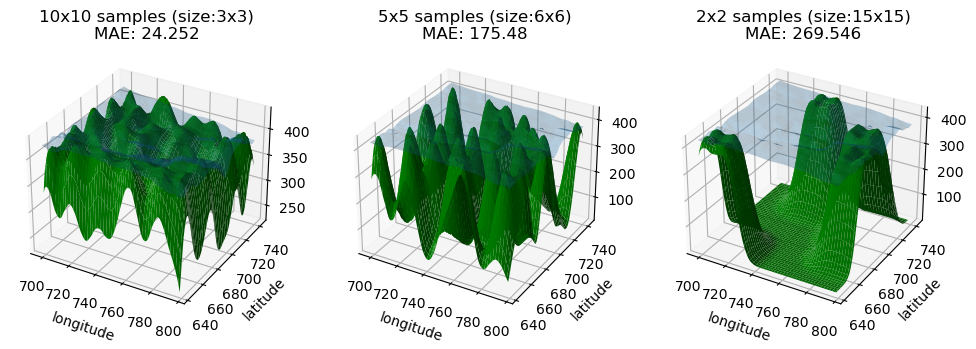

In [7]:
# 3D visualization

fig = plt.figure(figsize=(12, 4), facecolor="w")

for i, pred in enumerate(pipeline.predicted):
    ax = fig.add_subplot(eval(f"1{len(pipeline.predicted)}{i + 1}"), projection="3d")
    
    surf = ax.plot_surface(**pred(), color="g")
    ax.plot_surface(**area(), alpha=0.3)
    ax.set(
        xlabel="longitude",
        ylabel="latitude",
        title=f"{titles[i]}\nMAE: {pipeline.scores[i].round(3)}"
    );

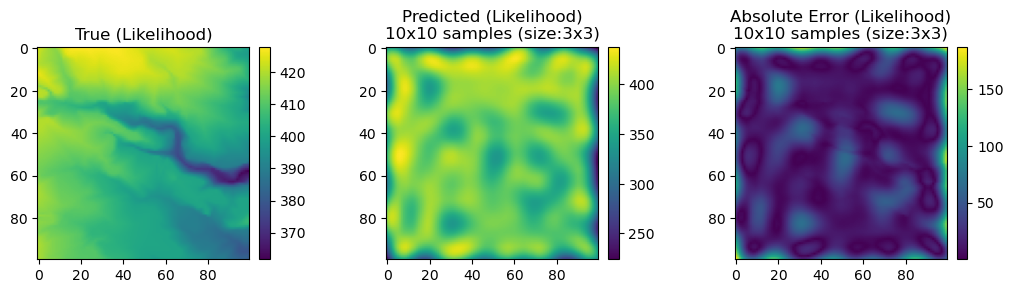

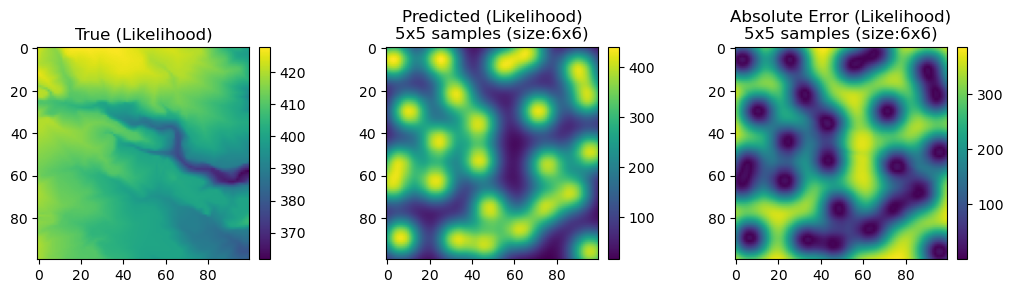

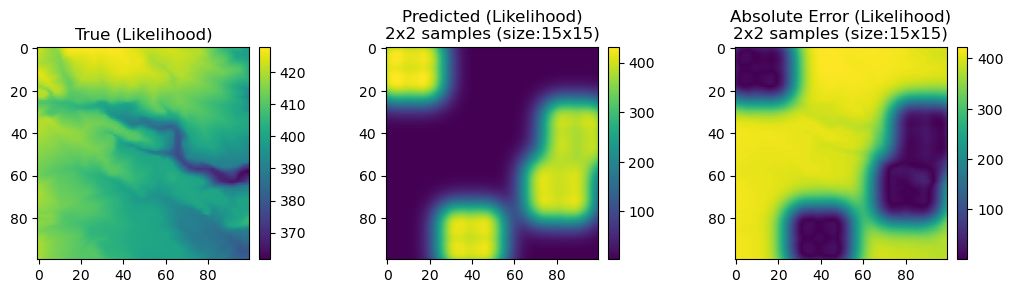

In [8]:
# 2D visualization

for pred, note in zip(
    pipeline.predicted,
    titles
):

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plt.subplots_adjust(wspace=0.5)

    for (i, v), title in zip(
        enumerate([
            pipeline.test.field.z, pred.z, ae(pred, pipeline.test.field).z
        ]),
        ["True", "Predicted", "Absolute Error"]
    ):
        im = ax[i].imshow(v, cmap="viridis")
        title += " (Likelihood)" if title == "True" else f" (Likelihood)\n{note}"
        ax[i].set(title=title)
        cax = make_axes_locatable(
            ax[i]
        ).append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)

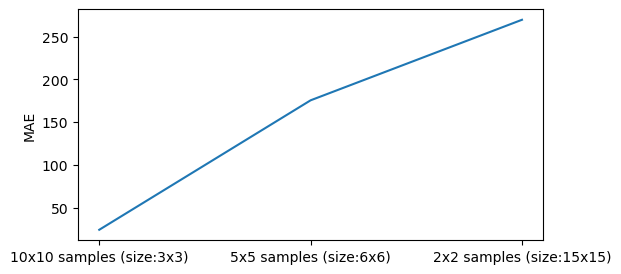

In [9]:
# MAE

fig, ax = plt.subplots(figsize=(6, 3))

plt.plot(
    titles,
    pipeline.scores
)

ax.set(ylabel="MAE");

---
## Result
- covariance kernel: KISSGP (RBF kernel)
- mean module: ConstantMean\
Under this setting of kernels, and with the constant summation of measured areas, the more counts (with the smaller areas) of mesurements will results in the better assumption of the overall field